# Pricing Optimization

## Goal:

The goal here is to evaluate whether a pricing test running on the site has been successful. The test has been conducted in order to predict the outcome of rising the cost of a product from actual 39 \$ to 59 \$.
In the experiment, 66% of the users have seen the old price and a random sample of 33% has seen the new higher price of 59\$.

## Data

We have 2 tables:

 **Fraud_Data** - information about each user's first transaction

**Columns:**

- **user_id**: the Id of the user. Can be joined to user_id in user_table

- **timestamp** : the date and time when the user hit for the first time company 
webpage. It is in user local time

- **source** : marketing channel that led to the user coming to the site. It can be:
 - ads["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from
google ads, yahoo ads, etc.

 - seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google search, yahoo, facebook, etc.

 - friend_referral : user coming from a referral link of another user
 - direct_traffic: user coming by directly typing the address of the site on the browser

- **device** : user device. Can be mobile or web

- **operative_system** : user operative system. Can be: "windows", "linux", "mac" for web,
and "android", "iOS" for mobile. 	Other	 if it is none of the above

- **test**: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old lower
price)

- **price **: the price the user sees. It should match test

- **converted **: whether the user converted (i.e. 1 -> bought the product) or not (0 -> left
the site without buying it).



**user_table** - Information about the each user

**Columns:**

- **user_id** : the Id of the user. Can be joined to user_id in test_results table
- **city** : the city where the user is located. Comes from the user ip address
- **country** : in which country the city is located
- **lat** : city latitude - should match user city

### Import dependencies

In [1]:
# Import main libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import Classifiers 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, partial_dependence
from sklearn.ensemble.partial_dependence import plot_partial_dependence

from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
# Import Model Evaluation tools
from sklearn.model_selection import train_test_split

In [4]:
# Import Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve

In [5]:
# Import preprocessing tools
from sklearn.preprocessing import LabelEncoder, imputation, StandardScaler

### Read in the data

In [6]:
path = './user_table.csv'
user_table = pd.read_csv(path)
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [7]:
test_results = pd.read_csv('test_results.csv', parse_dates=['timestamp'] )
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [8]:
#let's inspect data structure (dtypes, missing values, etc.)
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


We can notice timestamp series has not been converted to a datetime dtypes. 
Probably some data are broken and the conversion could not be implemented. Let's try to transform the series with pd.to_datetime
function to extract some insights.

In [9]:
#test_results.timestamp = pd.to_datetime(test_results.timestamp)

The problem seems to be related to mistaken data entry. There should be some minutes values greater than 59, according to
the value rror message. Let's check  for 60. The series is an object, then we can exploit the (str) functions.

In [10]:
test_results[test_results.timestamp.str.contains('60')].head()

,user_id,timestamp,source,device,operative_system,test,price,converted
54,370914,2015-04-24 12:60:46,direct_traffic,mobile,android,0,39,0
104,549807,2015-04-24 11:60:20,friend_referral,mobile,iOS,0,39,0
121,107010,2015-03-14 12:60:02,direct_traffic,web,windows,0,39,0
278,287830,2015-04-04 02:23:60,direct_traffic,web,windows,1,59,0
282,676183,2015-05-11 12:60:53,ads-google,web,windows,1,59,0


Apparently data entry is very compromised. More than 10.000 values are not correct in terms of minutes and seconds.
 Surely something to highlight to data owner, asking him to double check and correct. 
In order to continue with our analisys let's slice the string timestamp up to the date.
 We will loose  exact time, but at least we can still analize by date. After slicing we convert the format to datetime anyway.


In [11]:
test_results.timestamp = pd.to_datetime(test_results.timestamp.str.slice(0, 10,1), infer_datetime_format = True)

In [12]:
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10,seo-google,mobile,android,0,39,0
2,317970,2015-04-04,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24,ads_facebook,web,mac,0,39,0


In [13]:
#Let's join the two tables on the obvious key user_id
df = test_results.merge(user_table, on='user_id', how='outer')
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


### Sanity check of data

In [14]:
df.price.unique()# Ok: only two prices

array([39, 59], dtype=int64)

In [15]:
df.source.unique()

array(['ads_facebook', 'seo-google', 'ads-bing', 'direct_traffic',
       'ads-google', 'seo_facebook', 'friend_referral', 'ads_other',
       'ads-yahoo', 'seo-yahoo', 'seo-bing', 'seo-other'], dtype=object)

In [16]:
df.device.unique() # Ok: only two device typologies

array(['mobile', 'web'], dtype=object)

In [17]:
df.operative_system.unique()

array(['iOS', 'android', 'mac', 'windows', 'other', 'linux'], dtype=object)

In [18]:
df.test.value_counts(normalize=True) # OK: approximately a (2/3- 1/3) split for control group and test group

0    0.639921
1    0.360079
Name: test, dtype: float64

In [19]:
df.converted.value_counts(normalize=True)*100 # conversion rate for the entire dataset(<2%) within the common range

0    98.166667
1     1.833333
Name: converted, dtype: float64

In [20]:
test_results.user_id.duplicated().any() #let's check for dupes. 

False

All control group users should see 39\$ as a price and, conversely, all test group users shouls see 59\$. Let's verify that. If this is true, then when filtering control group with 59 \$, an empty query should be returned. And similarly it goes with test group.

In [21]:
df[(df.price == 59) & (df.test==0)].head() # Not true for control group. 210 obs do not match.

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
8238,500863,2015-05-06,ads_other,mobile,iOS,0,59,0,Arlington,USA,32.69,-97.13
8369,791541,2015-04-13,ads-bing,web,windows,0,59,0,Bridgeport,USA,41.19,-73.20
11555,402699,2015-05-16,direct_traffic,mobile,other,0,59,0,Carson City,USA,39.15,-119.74
12848,624380,2015-05-22,seo-google,mobile,iOS,0,59,0,NaN,NaN,NaN,NaN
14630,577544,2015-04-24,seo-google,mobile,android,0,59,0,Plano,USA,33.05,-96.75


In [22]:
df[(df.price == 39) & (df.test==1)].head() # Not true even with test group. 155 obs do not match

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
1457,686486,2015-03-28,seo-other,mobile,android,1,39,0,Kennewick,USA,46.20,-119.17
1912,128338,2015-05-15,direct_traffic,mobile,android,1,39,0,Los Angeles,USA,34.11,-118.41
2337,220590,2015-03-27,ads-google,web,windows,1,39,0,Saint Louis,USA,38.64,-90.24
3147,246390,2015-05-30,direct_traffic,mobile,iOS,1,39,0,Bellevue,USA,41.16,-95.92
4277,906451,2015-04-05,ads-google,web,windows,1,39,0,West Covina,USA,34.05,-117.91


Another inconsistent result to highlight to data owner. For our purpose, in light of the fact that total amount of 
 inconsistent data is minimal, compared to the whole numbers, let's filter the dataset dropping all inconsistent data by index.

In [23]:
df = df.drop(index=df[(df.price == 39) & (df.test==1)].index)

In [24]:
df = df.drop(index=df[(df.price == 59) & (df.test==0)].index)

In [25]:
len(df) # Ok: total observations have been reduced by (155+210) elements

316435

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316435 entries, 0 to 316799
Data columns (total 12 columns):
user_id             316435 non-null int64
timestamp           316435 non-null datetime64[ns]
source              316435 non-null object
device              316435 non-null object
operative_system    316435 non-null object
test                316435 non-null int64
price               316435 non-null int64
converted           316435 non-null int64
city                275294 non-null object
country             275294 non-null object
lat                 275294 non-null float64
long                275294 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 31.4+ MB


# Exploratory Data Analysis (EDA)

In [27]:
# plotting settings
#plt.style.use('seaborn-whitegrid')
plt.style.use("ggplot")
figsize=(20,6)

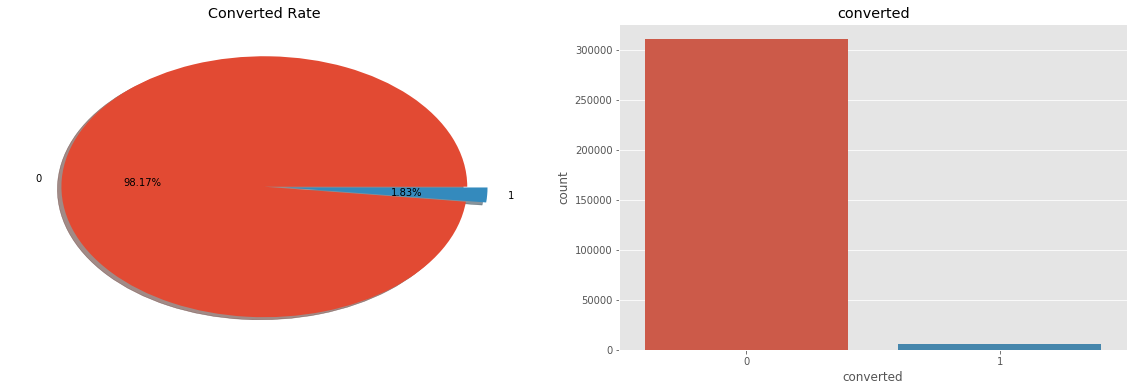

In [28]:
f, ax = plt.subplots(1,2,figsize=figsize)
df['converted'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%',ax=ax[0],shadow=True)
ax[0].set_title('Converted Rate')
ax[0].set_ylabel('')
sns.countplot('converted', data=df, ax=ax[1])
ax[1].set_title('converted');

###### Conversion by device

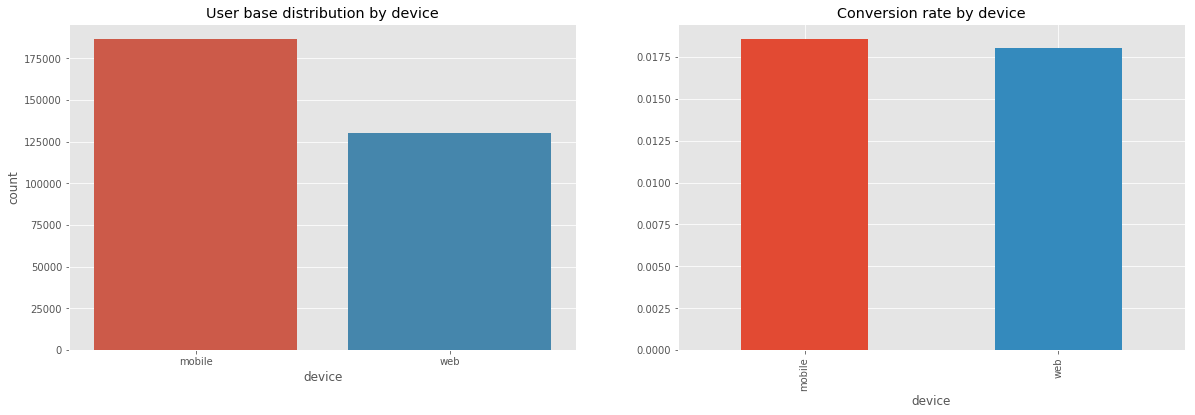

In [29]:
f, ax = plt.subplots(1,2,figsize=figsize)
sns.countplot('device', data=df, ax=ax[0])
ax[0].set_title('User base distribution by device')
df.groupby('device').converted.mean().sort_values(ascending=False).plot(kind='bar')
ax[1].set_title('Conversion rate by device');

No significant difference in conversion rate between mobile and web

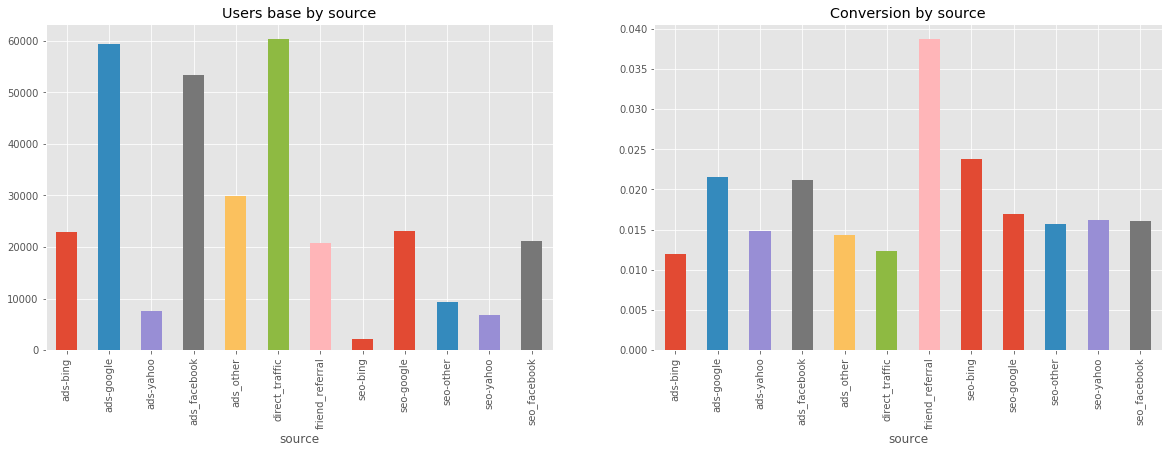

In [30]:
f, ax = plt.subplots(1,2,figsize=figsize)
df.groupby('source')['converted'].count().plot.bar(ax=ax[0])
ax[0].set_title('Users base by source')
df.groupby('source')['converted'].mean().plot.bar()
ax[1].set_title('Conversion by source');


Friend-referral conversion rate almost doubles other sources

###### Conversion by city

In [31]:
df.country.unique() #only american cities, apart from missing values

array(['USA', nan], dtype=object)

In [32]:
df.city.nunique() # many cities

923

In [33]:
df.city.describe() #lots of New Yorkers

count       275294
unique         923
top       New York
freq         25718
Name: city, dtype: object

In [34]:
df.city.value_counts().head(30)

New York          25718
Chicago            7144
Houston            6697
San Antonio        4628
Los Angeles        4136
San Jose           3347
Indianapolis       3212
Jacksonville       2905
Philadelphia       2533
Las Vegas          2424
Austin             2291
Seattle            2201
Oklahoma City      1796
Charlotte          1763
Tucson             1728
Virginia Beach     1712
Oakland            1686
Nashville          1581
Mesa               1556
Memphis            1534
Minneapolis        1466
Fort Worth         1429
Buffalo            1303
Raleigh            1291
New Orleans        1261
Springfield        1246
Tampa              1216
Dallas             1205
Detroit            1177
Plano              1077
Name: city, dtype: int64

 We know that some data were missing in the user table, therefore some cities values are NaN

In [35]:
# replace missing values in cities with 'Not Found'
df['city'] =df['city'].replace(np.nan, 'Not Found') 
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [36]:
#Let's keep only the top 30 cities 
top_30 = list(df.groupby('city')[['user_id']].count().sort_values('user_id', ascending = False).index)[0:30]
top_30 = top_30[1:] # to remove 'not found' from the top30 list

In [37]:
#Replace everything else with 'other'
df['city'] = np.where(df['city'].isin(top_30), df.city, 'other')

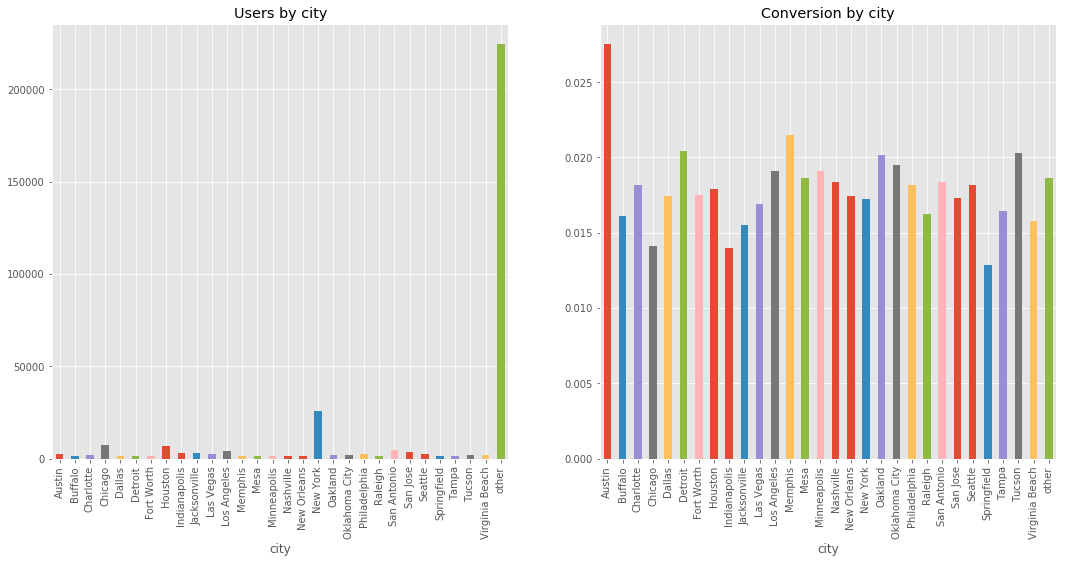

In [38]:
f, ax = plt.subplots(1,2,figsize=(18,8))
df.groupby('city')['converted'].count().plot.bar(ax=ax[0])
ax[0].set_title('Users by city')
df.groupby('city')['converted'].mean().plot.bar()
ax[1].set_title('Conversion by city');

Austin-TX has by far the higher conversion rate

###### Conversion by Operative System

In [39]:
df.groupby('operative_system')['converted'].mean().sort_values(ascending=False)

operative_system
mac        0.023987
iOS        0.022328
windows    0.016966
android    0.014919
other      0.012981
linux      0.008232
Name: converted, dtype: float64

In [40]:
df[df.operative_system=='linux']['converted'].value_counts() 

0    4096
1      34
Name: converted, dtype: int64

Only 34 Linux users converted out of around 4100. Some bug that  needs be fixed. Linux users better be removed from the dataset

In [41]:
df = df[df.operative_system!='linux'] 

IOS performs much better (almost as high as two times better) than android. Improvemenents suggested for smartphones that are not Apple manifactured.

In [42]:
len(df) # sanity check

312305

### T-test

Time to analize T-test results. Let's start with quantifiyng the mean conversion rate for test and control group

In [43]:
df.groupby('test')[['converted']].mean()*100 

,converted
test,
0,1.994878
1,1.582256


According to the data, conversion rate dropped some 25% for test group. The 1st step is to calculate the p-value of the test in order to verify is the performed test has statistical significance.

In [44]:
#let's split the data in Control group (the 0s) and Test group (the 1s).
zero = df[df['test'] == 0]
one = df[df['test'] == 1]

In [45]:
import scipy as sc
from scipy import stats 
sc.stats.ttest_ind(zero['converted'], one['converted'], equal_var = False, axis = 0)

Ttest_indResult(statistic=8.482008978327446, pvalue=2.2249855107660096e-17)

** p-value greatly lesser than 0.05** indicates that we can reject the null hypothesis and thus we could conclude that
 mean difference between the distribution is not due to chance. 
 
 Let's check if the group were created randomly, using a decision tree to verify if it splits (2/3 1/3) as per original data, or some incongruency has been introduced 
 during control/test group split creation. We will check fot the first 2 or 3 depths.

### Data processing for Machine Learning Analysis

###### Create Feature Matrix X

In [46]:
features = ['source','device', 'operative_system', 'city' ]
X = df[features].copy() # make a copy of the original dataframe to avoid warning error
X.shape

(312305, 4)

###### Label encoding of categorical variables

In [47]:
lb = LabelEncoder() # instantiate the encoder
for feature in X.select_dtypes(include = ['O']).columns.values: # loop through all the feature spaces and pick only the categorical variables
    X[feature]= lb.fit_transform(X[feature])

In [48]:
X.info() # final check on feature matrix X values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312305 entries, 0 to 316799
Data columns (total 4 columns):
source              312305 non-null int64
device              312305 non-null int64
operative_system    312305 non-null int64
city                312305 non-null int64
dtypes: int64(4)
memory usage: 11.9 MB


Feature matrix full of numeric values only and showing no presence of missing values. Ready for manipulation

###### Create response vector y

In [49]:
y= df.test #  pay attentkion that the label here is test series (not converted)

### Decision Tree Classifier

In [50]:
tree = DecisionTreeClassifier(random_state=0, criterion = 'entropy', max_depth = 3)
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

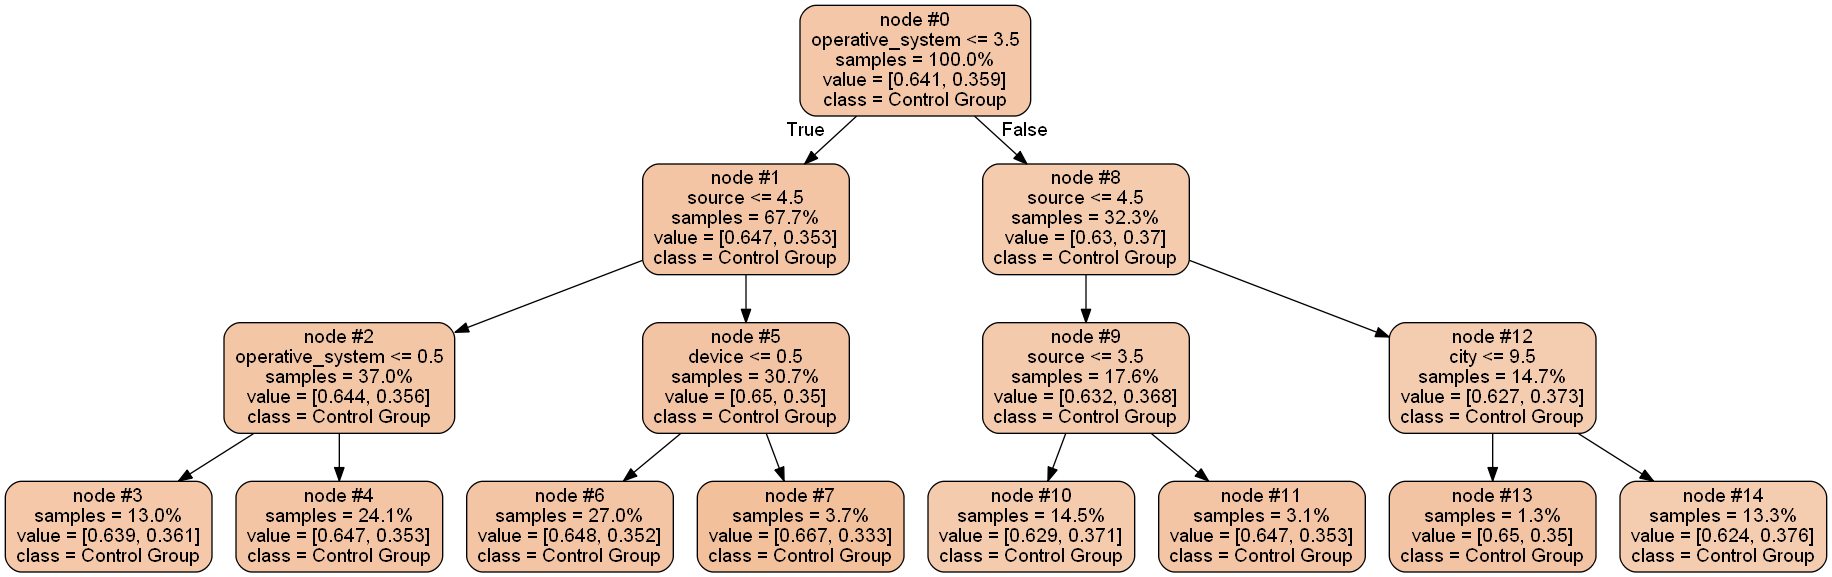

In [51]:
export_graphviz(tree, out_file='tree.dot', feature_names=X.columns, class_names=['Control Group', 'TEST Group'],
               impurity=False, filled=True, node_ids= True, proportion=True, rounded=True)
from IPython.display import Image
Image(filename='tree.png') 

 The tree confirms that the it splits  maintaing the same initial proportion, as we can derive from the fact  that all the leaves show a value proportion of ca. 0.666/0.333. 
 
 Hence we can assert the **test was conclusive**, in other words the split was performed randomly 

### Revenues Optimization

T-test performed proved to be statistically significant showing a drop in conversion mean of some 25%. Nevertheless the test group acquired the product at a much higher price (59 $). Therefore we might ourselves ask if still from a pure economic point of view is suggestable to rise product's price. 

To answer this question we need to calculate a new variable (revenues) and check the outcomes in the 2 groups.

In [52]:
df['revenues']= df.converted*df.price

In [53]:
df.groupby('test')[['revenues']].mean()

,revenues
test,
0,0.778002
1,0.933531


 Metric of revenues per user went up, when price was risen to 59 $, showing a consistent increment. Therefore increasing the price
from a strict economic point of view seems profitable. 
It is important, though, to keep in mind the drawbacks of increasing product price: reducing # of customers might affect revenues
in the long term, you will have less word of mouth since you have less customers. If a company is especially focused on growth (like it is often the case for small startups), they might be OK with less revenue, but higher number of customers     


## Insights on the data

- Friend-referral conversion rate proved to be the most effective mean, maybe giving some incentives to existing satisfied customers might lead to increase CR even more 
- Austin customers conversion rate much better than others. Target those client with e-mails
- Mobile version working as good as desktop one, no action needed in this direction

### Test duration

In order to estimate the proper test duration we must calculate first and foremost test size parameter to gain statistical significance. We can do that setting the percentage of type I and type II errors we are willing to accept in our estimate.
In statistic usual parameters are:
- α = 0.05
- Power = 0.8 ( which corresponds to ß = 0.2)
- Effect size we aim to detect ( we can calculate this parameter knowing mean and σ of the proprtion we are testing)

Using a software like G*power we can compute required sample size once all other params are set. 

###### Let's perform a z-test using a software like G*Power, setting 'difference between two indipendent proportions' and computing 'required sample size' given α, power and effect size. 
Inputing one tail, p1=0.0155, p2=0.02, α=0.05, power=0.8, allocation ratio N2/N1 =0.66, we obtain a total total sample size of 22403, of which 13496 for p1 (control group) and 8907 for p2 (test group).


In [54]:
df.timestamp.max()-df.timestamp.min() # test went trough for 3 months

Timedelta('90 days 00:00:00')

In [55]:
df.groupby('timestamp')['user_id'].count().mean() #average daily users visitors to the site

3431.923076923077

If we divide the total number of sample size by the average daily users we would need to split run test for around 7 days, in order to reach a significant and reliable sample size. 

We consider in any case a miminum timespan of 14 days in order to capture potential weekly patterns. So the test has been run for too long wasting precious time and resources.